# Unsupervised image denoising

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os
import math
import torch as tf

## Hyper parameters

In [2]:
device        = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ==================================================
# determine optimal hyper-parameters to obtain best testing performance
number_epoch    = 50
size_minibatch  = 64
learning_rate   = 0.1
# ==================================================

In [3]:
from google.colab import drive 
drive.mount('/content/drive/')

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'

import sys
sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_1_1
import wisdm_2_0
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
origianl_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (14423, 200, 3) y_train.shape:  (14423, 6)


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(origianl_x, original_y, random_state=42, stratify=original_y, test_size=0.2)

## Costumize dataloader for pytorch

In [8]:
class dataset (Dataset):
    def  __init__(self, data, label):

        self.data    = data
        self.label    = label
            
    def __getitem__(self, index):

        data    = self.data[index]
        label   = self.label[index]
        return (data, label)

    def __len__(self):
        return self.data.shape[0]

## Construct datasets and dataloaders for training and testing

In [9]:
## transformer를 통과하기 위해 데이터 shape 변경
x_train = x_train.reshape(-1, x_train.shape[2], x_train.shape[1])
x_test = x_test.reshape(-1, x_test.shape[2], x_test.shape[1])

dataset_train = dataset(x_train, y_train) 
dataset_test  = dataset(x_test, y_test) 

dataloader_train = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, num_workers=2)
dataloader_test  = DataLoader(dataset_test,  batch_size=size_minibatch, shuffle=False, drop_last=True, num_workers=2) 

## Class for the neural network

In [10]:
class my_MultiHeadAttention(nn.Module):
    def __init__(self, emb_size=200, num_heads=1):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.multihead = nn.MultiheadAttention(emb_size, num_heads, batch_first=True)

    def forward(self, inputs):
        # split keys, queries and values in num_heads
        x = self.multihead(inputs, inputs, inputs, need_weights=False)
        return x

In [11]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,max_len,d_model,device):
        super(PositionalEncoding,self).__init__()
        
        self.encoding = torch.zeros(max_len,d_model,device = device)
        self.encoding.requires_grad = False # we don't need to compute gradient
        
        pos = torch.arange(0,max_len,device=device)
        pos = pos.float().unsqueeze(dim = 1)
        
        _2i = torch.arange(0,d_model,step = 2,device = device).float()
        
        self.encoding[:,0::2] = torch.sin(pos/(10000**(_2i/d_model)))
        self.encoding[:,1::2] = torch.cos(pos/(10000**(_2i/d_model)))
        
    def forward(self,x):
        batch_size,seq_len = x.size()
        
        return self.encoding[:seq_len,:]

class ScaleDotProductAttention(nn.Module):
    '''
    Compute scale dot product attention
    실질적인 attention score을 계산하는 클래스
    '''
    def __init__(self):
        super(ScaleDotProductAttention,self).__init__()
        self.softmax = nn.Softmax()
        
    def forward(self,q,k,v,mask = None, e = 1e-12):
        # input is 4 dimension tensor
        # [batch_size,head,length,d_tensor]
        batch_size,head,length,d_tensor = k.size()
        
        # 1. dot product Query with Key^T to compute similarity
        k_t = k.view(batch_size,head,d_tensor,length)
        score = (q @ k_t) / math.sqrt(d_tensor) # @연산은 np.matmul과 같은 역할
        
        '''
        Note) '@' operator
        If either argument is N-D, N > 2, 
        it is treated as a stack of matrices residing in the last two indexes and broadcast accordingly.
        '''
        
        # 2. applying masking(optional)
        if mask is not None:
            score = score.masked_fill(mask == 0 ,-e)
        
        # 3. pass tem softmax to make [0,1] range
        score = self.softmax(score)
        
        # 4. Multiply with Value
        v = score @ v
        
        return v, score

class MultiHeadAttention(nn.Module):
    
    def __init__(self,d_model,n_head):
        super(MultiHeadAttention,self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model,d_model)
        self.w_k = nn.Linear(d_model,d_model)
        self.w_v = nn.Linear(d_model,d_model)
        self.w_concat = nn.Linear(d_model,d_model)
    
    def split(self,tensor):
        '''
        splits tensor by number of head
        
        param tensor = [batch_size,length,d_model]
        out = [batch_size,head,length,d_tensor]
        
        d_model을 head와 d_tensor로 쪼개는걸로 이해하면 될듯. 
        d_tensor는 head의 값에 따라 변함.(head값은 정해주는 값이기 때문..)
        '''
        batch_size,length,d_model = tensor.size()
        
        d_tensor = d_model//self.n_head
        
        tensor = tensor.view(batch_size,self.n_head,length,d_tensor)
        
        return tensor
    
    def concat(self,tensor):
        '''
        inverse function of self.split(tensor = torch.Tensor)
        
        param tensor = [batch_size,head,length,d_tensor]
        out = [batch_size,length,d_model]
        '''
        batch_size,head,length,d_tensor = tensor.size()
        d_model = head*d_tensor
        
        tensor = tensor.view(batch_size,length,d_model)
        return tensor
    
    def forward(self,q,k,v,mask = None):
        
        #1. dot product with weight metrics
        q,k,v = self.w_q(q),self.w_k(k),self.w_v(v)
        
        # 2. split tensor by number of heads
        q,k,v = self.split(q),self.split(k),self.split(v)
        
        # 3. do scale dot product to compute similarity (attention 계산)
        out,attention = self.attention(q,k,v, mask = mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)
        
        return out

In [12]:
# 수정: 오토 인코더의 인코더처럼 만들기 위해 마지막 Linear에서 그 크기를 줄여준다.
class FeedForwardBlock_Encoder(nn.Module):
    def __init__(self, in_channel, out_channel, reduction=1):
        super(FeedForwardBlock_Encoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channel, in_channel, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm1d(in_channel)
        
        self.conv2 = nn.Conv1d(in_channel, out_channel, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm1d(out_channel)            

        self.pool = nn.MaxPool1d(2, 2)
        self.reduction = reduction

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.batch1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch2(x)

        if self.reduction == 2:
            x = self.pool(x)

        return x

In [13]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim=768, in_channel=16, out_channel=16, reduction=1, **kwargs):
        super(TransformerEncoderBlock, self).__init__()

        self.laynorm1 = nn.LayerNorm(dim)
        self.multihead1 = MultiHeadAttention(dim, 1)

        self.laynorm2 = nn.LayerNorm(dim)
        self.ff = FeedForwardBlock_Encoder(in_channel, out_channel, reduction=reduction)

    def forward(self, inputs):

        _x = inputs
        x = self.laynorm1(inputs)
        x = self.multihead1(x, x, x)
        x += _x

        x = self.laynorm2(x)
        x = self.ff(x)

        return x

In [14]:
# 수정: 오토 인코더의 인코더처럼 만들기 위해 마지막 Linear에서 그 크기를 줄여준다.
class FeedForwardBlock_Decoder(nn.Module):
    def __init__(self, in_channel, out_channel, amp=1):
        super(FeedForwardBlock_Decoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channel, in_channel, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm1d(in_channel)
        
        self.conv2 = nn.Conv1d(in_channel, out_channel, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm1d(out_channel)            

        self.pool = nn.Upsample(scale_factor=2, mode="nearest")
        self.amp = amp


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.batch1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch2(x)

        if self.amp == 2:
            x = self.pool(x)
        return x

In [15]:
# Now create the Transformer Encoder Block
class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim=768, in_channel=16, out_channel=16, amp=1, **kwargs):
        super(TransformerDecoderBlock, self).__init__()

        self.laynorm1 = nn.LayerNorm(dim)
        self.multihead1 = MultiHeadAttention(dim, 1)

        self.laynorm2 = nn.LayerNorm(dim)
        self.ff =  FeedForwardBlock_Decoder(in_channel, out_channel, amp)

    def forward(self, inputs):

        _x = inputs
        x = self.laynorm1(inputs)
        x = self.multihead1(x, x, x)
        x += _x

        x = self.laynorm2(x)
        x = self.ff(x)
        return x

In [16]:
class Conseuctive_Conv(nn.Sequential):
    def __init__(self, dim):
        super().__init__(
            nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(dim, dim, kernel_size=3, stride=1, padding=1)
        )

class Encoder(nn.Module):
    def __init__(self, dim, channel):
        super(Encoder, self).__init__()

        self.dim = dim
        self.channel = channel

        self.conv1 = Conseuctive_Conv(channel*20)
        self.conv2 = Conseuctive_Conv(channel*40)

        self.encoder12 = TransformerEncoderBlock(dim=dim,     in_channel=channel,   out_channel=channel*20,  reduction=2, **kwargs)
        self.encoder22 = TransformerEncoderBlock(dim=dim//2,  in_channel=channel*20, out_channel=channel*40,  reduction=2, **kwargs)
        self.encoder32 = TransformerEncoderBlock(dim=dim//4,  in_channel=channel*40, out_channel=channel*80,  reduction=2, **kwargs)

    def forward(self, inputs):

        x = self.encoder12(inputs)    
        x = self.conv1(x)
        x = self.encoder22(x)
        x = self.conv2(x)
        x = self.encoder32(x)

        return x

class Decoder(nn.Module):
    def __init__(self, dim, channel):
        super(Decoder, self).__init__()

        self.dim = dim
        self.channel = channel

        self.conv3 = Conseuctive_Conv(channel*40)
        self.conv4 = Conseuctive_Conv(channel*20)

        self.decoder12 = TransformerDecoderBlock(dim=dim//8,  in_channel=channel*80, out_channel=channel*40, amp=2, **kwargs)
        self.decoder22 = TransformerDecoderBlock(dim=dim//4,  in_channel=channel*40, out_channel=channel*20, amp=2, **kwargs)
        self.decoder32 = TransformerDecoderBlock(dim=dim//2,  in_channel=channel*20, out_channel=channel,   amp=2, **kwargs)

    def forward(self, inputs):

        x = self.decoder12(inputs)
        x = self.conv3(x)
        x = self.decoder22(x)
        x = self.conv4(x)
        x = self.decoder32(x)

        return x


class Transformer_Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Transformer_Autoencoder, self).__init__()

        dim = 200
        channel = 3

        self.conv1 = Conseuctive_Conv(channel*20)
        self.conv2 = Conseuctive_Conv(channel*40)

        self.conv3 = Conseuctive_Conv(channel*40)
        self.conv4 = Conseuctive_Conv(channel*20)

        self.encoder12 = TransformerEncoderBlock(dim=dim,     in_channel=channel,   out_channel=channel*20,  reduction=2, **kwargs)
        self.encoder22 = TransformerEncoderBlock(dim=dim//2,  in_channel=channel*20, out_channel=channel*40,  reduction=2, **kwargs)
        self.encoder32 = TransformerEncoderBlock(dim=dim//4,  in_channel=channel*40, out_channel=channel*80,  reduction=2, **kwargs)

        self.decoder12 = TransformerDecoderBlock(dim=dim//8,  in_channel=channel*80, out_channel=channel*40, amp=2, **kwargs)
        self.decoder22 = TransformerDecoderBlock(dim=dim//4,  in_channel=channel*40, out_channel=channel*20, amp=2, **kwargs)
        self.decoder32 = TransformerDecoderBlock(dim=dim//2,  in_channel=channel*20, out_channel=channel,   amp=2, **kwargs)


    def forward(self, inputs):

        x = self.encoder12(inputs)    
        x = self.conv1(x)
        x = self.encoder22(x)
        x = self.conv2(x)
        x = self.encoder32(x)

        x = self.decoder12(x)
        x = self.conv3(x)
        x = self.decoder22(x)
        x = self.conv4(x)
        x = self.decoder32(x)

        return x
        

In [ ]:
class Supervied_Autoencoder(nn.Module):
    def __init__(self, dim, channel):
        super(Supervied_Autoencoder, self).__init__()
        
        self.dim = dim
        self.channel = channel

        self.encoder = Encoder(dim, channel)
        self.decoder = Decoder(dim, channel)

        self. 

## model summary 용

In [ ]:
# from torchsummary import summary as summary_

# model = Transformer_Autoencoder().to(device)
# summary_(model, (3, 200))

## 모델링 과정을 위해 필요한 함수 정의

In [18]:
def compute_prediction(model, input):
    prediction = model(input)
    return prediction

In [19]:
def compute_loss(input, prediction):
    
    mse = nn.MSELoss()
    
    # ==================================================
    # fill up the blank
    loss_mse = mse(prediction, input)
    # ==================================================
    
    loss_mse_value = loss_mse.item() 
    
    return loss_mse, loss_mse_value

In [20]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    bCorrect = (b_Prediction == label)
    accuracy = bCorrect.float().mean() * 100
    # ================================================================================ 

    return accuracy

## 모델링 과정 정리를 위한 배열

In [21]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## Build the network

In [22]:
model = Transformer_Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    model.train()

    for index_batch, (data, label) in enumerate(dataloader_train):

        data_train = data.to(device)
        label_train = label.to(device)
        
        prediction_train                = compute_prediction(model, data_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, data_train)
        # accuracy_train                  = compute_accuracy(prediction_train, data_train).to("cpu")
        # accuracy_train = accuracy_train.numpy()

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        # accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    # accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    # accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    with torch.no_grad():
        model.eval()

    for index_batch, (data, label) in enumerate(dataloader_test):

        data_test = data.to(device)
        label_test = label.to(device)
        
        prediction_test             = compute_prediction(model, data_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, data_test)
        # accuracy_test               = compute_accuracy(prediction_test, data_test).to("cpu")
        # accuracy_test = accuracy_test.numpy()

        loss_test_epoch.append(loss_value_test)
        # accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    # accuracy_mean_test[i]  = np.mean(accuracy_test_epoch)
    # accuracy_std_test[i]   = np.std(accuracy_test_epoch)

    # print(f"epoch : {i}, train acc : {np.mean(accuracy_train_epoch)}, train loss : {np.mean(loss_train_epoch)}")
    # print(f"epoch : {i}, test acc : {np.mean(accuracy_test_epoch)}, test loss : {np.mean(loss_test_epoch)}")
    # print()

    print(f"epoch : {i}, train loss : {np.mean(loss_train_epoch)}")
    print(f"epoch : {i}, test loss : {np.mean(loss_test_epoch)}")
    print()

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch : 0, train loss : 0.29057515656782523
epoch : 0, test loss : 0.0905530196097162

epoch : 1, train loss : 0.09110138374898169
epoch : 1, test loss : 0.08988222595718172

epoch : 2, train loss : 0.09182590531806151
epoch : 2, test loss : 0.08985763324631585

epoch : 3, train loss : 0.09187481266756853
epoch : 3, test loss : 0.0899928437338935

epoch : 4, train loss : 0.09184577920370632
epoch : 4, test loss : 0.09026048514578078

epoch : 5, train loss : 0.09186905196143522
epoch : 5, test loss : 0.0899471566081047

epoch : 6, train loss : 0.09181519088645776
epoch : 6, test loss : 0.08985524210664961

epoch : 7, train loss : 0.09183365404605866
epoch : 7, test loss : 0.08985777944326401

epoch : 8, train loss : 0.09190789022379452
epoch : 8, test loss : 0.08992664482858446

epoch : 9, train loss : 0.09181524788339933
epoch : 9, test loss : 0.09015444699260923

epoch : 10, train loss : 0.09189969992472066
epoch : 10, test loss : 0.08992915136946572

epoch : 11, train loss : 0.091824

## Plot 함수

In [27]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

[plot the training loss]



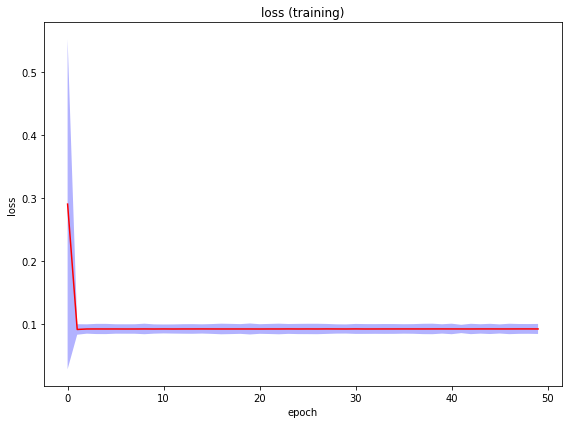

In [26]:
print('[plot the training loss]')
print('') 
plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [ ]:
print('[plot the testing loss]')
print('') 
plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [ ]:
print('[plot the traning accuracy]') 
print('') 
plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'Accuracy (training)')

In [ ]:
print('[plot the testing accuracy]') 
print('') 
plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'Accuracy (testing)')